<a href="https://colab.research.google.com/github/vasukiup/ProcessSequencePrediction/blob/master/ML_models_Sonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

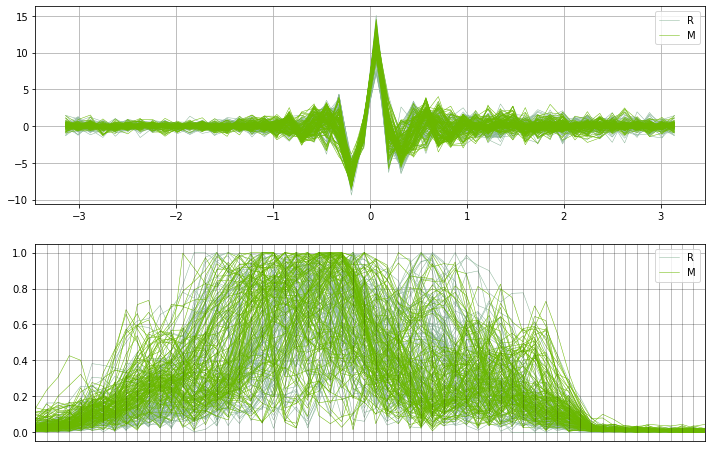

In [25]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data', header=None, prefix='X')
df.shape
df.rename(columns={'X60':'Label'}, inplace=True)
df.Label = df.Label.astype('category')

df.head()

import pandas.plotting as tools
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,1,figsize=(12,8))
tools.andrews_curves(df, 'Label', samples=50, linewidth=0.5, ax=axes[0])
tools.parallel_coordinates(df, 'Label', linewidth=0.5, ax=axes[1], axvlines_kwds={'linewidth':0.5, 'color':'black', 'alpha':0.5})
axes[1].set_xticks([])
axes[1].margins(0.05)
pass


#from pandas.tools.plotting import andrews_curves, parallel_coordinates

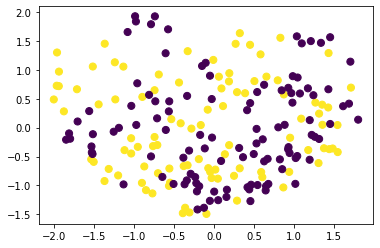

In [24]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds = MDS(n_components=2)
mds_data = mds.fit_transform(df.iloc[:, :-1])
plt.scatter(mds_data[:,0], mds_data[:,1], c=df.Label.cat.codes, s=50);

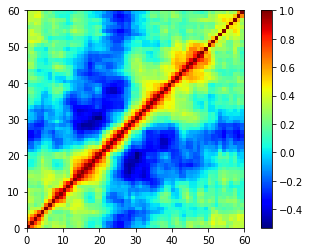

In [29]:
heatmap = plt.pcolor(df.corr(), cmap='jet')
plt.colorbar(heatmap)
plt.gca().set_aspect('equal')

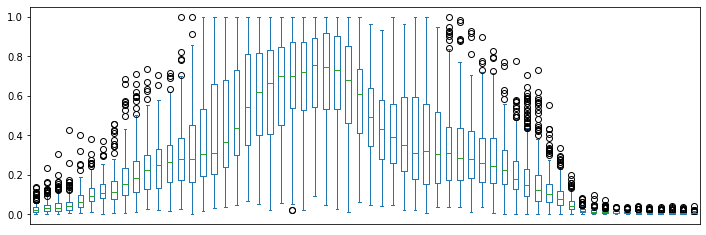

In [32]:
df.plot.box(figsize=(12,4), xticks=[])
pass

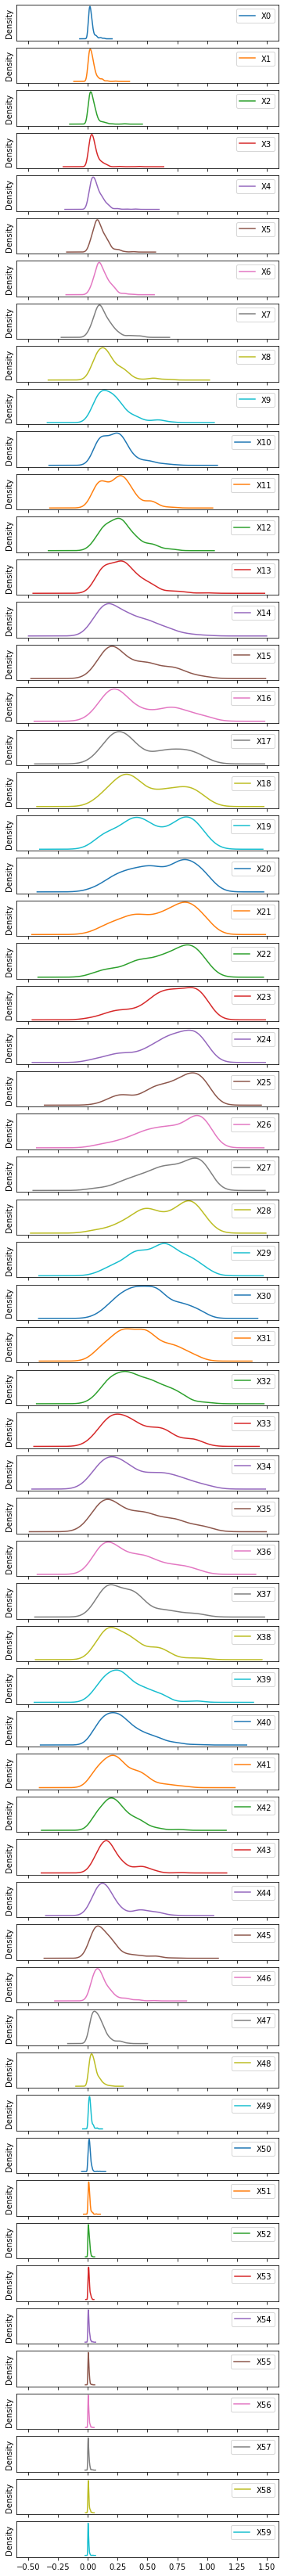

In [33]:
df.plot.density(figsize=(6,60), subplots=True, yticks=[])
pass 

In [37]:
from sklearn.preprocessing import StandardScaler, RobustScaler
data, labels = df.iloc[:, :-1], df.iloc[:, -1]
#data.head()
data_scaled = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)
data_scaled.head(3)

data_robust = pd.DataFrame(RobustScaler().fit_transform(data), columns=data.columns)
data_robust.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59
0,-0.126126,0.200000,0.217949,-0.581931,0.528726,0.096125,0.642271,0.538267,1.163123,0.182309,...,0.750000,-0.920635,-0.310433,0.723288,-0.037736,1.595142,1.791822,0.385185,0.390977,-0.387097
1,1.013514,0.682540,1.282051,0.619315,0.896746,2.476155,1.486320,2.646482,1.330279,0.665714,...,-0.112903,-0.317460,-0.066158,-0.493151,0.238994,1.983806,1.197026,-0.133333,-0.180451,-0.165899
2,0.153153,0.869841,1.938462,1.601246,0.560868,2.024590,1.862517,2.971685,2.987903,2.775925,...,-0.854839,1.248677,0.717557,0.021918,1.320755,2.842105,3.814126,1.570370,0.466165,0.460829


In [48]:
from sklearn.decomposition import PCA
pca=PCA()
data_scaled_pca=pd.DataFrame(pca.fit_transform(data_scaled), columns=data.columns)
data_scaled_pca.shape
v=pca.explained_variance_ratio_
vc=v.cumsum()
#it=data_scaled_pca.iterator()
#pd.DataFrame(list(zip(it.count()), v, vc)), columns=['pc', 'explained', 'cumsum']).head(10)


In [50]:
import numpy as np
n_comps = 1 + np.argmax(vc>0.95)
n_comps

30

In [55]:
data_scaled_pca = data_scaled_pca.iloc[:, :n_comps]
data_scaled_pca.shape
data_scaled_pca.head()
data_pca=pd.concat([data_scaled_pca, labels], axis=1)
data_pca.shape

(208, 31)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_scaled_pca, labels, test_size=0.33, random_state=42 )
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)


0.7971014492753623

In [64]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svc=svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)
pass

In [65]:
clf.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [66]:
clf.best_score_

0.7693121693121693

In [67]:
clf.score(X_test, y_test)

0.8260869565217391

In [69]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           M       0.82      0.87      0.85        38
           R       0.83      0.77      0.80        31

    accuracy                           0.83        69
   macro avg       0.83      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69



In [70]:
## random forest
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=.33, random_state=42)
parameters = [{'n_estimators': list(range(25, 201, 25)),
               'max_features': list(range(2, 15, 2))}]
clf = GridSearchCV(RandomForestClassifier(), parameters,
                   cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)
pass  

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 12, 14],
                          'n_estimators': [25, 50, 75, 100, 125, 150, 175,
                                           200]}],
             scoring='accuracy')

In [71]:
clf.best_params_

{'max_features': 4, 'n_estimators': 75}

In [72]:
clf.score(X_test, y_test)

0.8840579710144928

In [73]:
imp = clf.best_estimator_.feature_importances_
idx = np.argsort(imp)


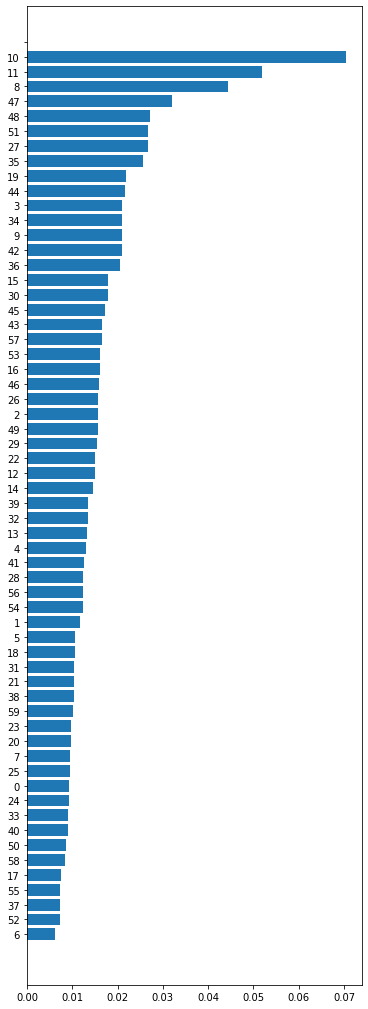

In [76]:
plt.figure(figsize=(6,18))
plt.barh(range(len(imp)), imp[idx])
plt.yticks(np.arange(len(imp)+0.5), idx)
pass

In [79]:
# using pipeline
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=.33, random_state=42)
scaler=StandardScaler()
pca = PCA()
clf = LogisticRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('clf', clf)])
n_components = [20,30,40,50, 60]
Cs = np.logspace(-4, 4, 1) 
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, clf__C=Cs), n_jobs=-1)
estimator.fit(X_train, y_train)
pass

In [80]:
estimator.best_estimator_.named_steps['pca'].n_components

20

In [82]:
estimator.score(X_test, y_test)

0.5507246376811594

In [84]:
y_true, y_pred = y_test, estimator.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           M       0.55      1.00      0.71        38
           R       0.00      0.00      0.00        31

    accuracy                           0.55        69
   macro avg       0.28      0.50      0.36        69
weighted avg       0.30      0.55      0.39        69

